# 第六章 使用scikit-learn构建模型

## 1.使用sklearn处理wine、winequality数据集

### （1）读取数据集

In [2]:
import pandas as pd
import numpy as np

w = pd.read_csv('wine.csv')
wq_raw = pd.read_csv('winequality.csv')

wq_col = np.array([i.replace('\"',"") for i in wq_raw.columns.tolist()[0].split(';')])
wq = np.array([eval(j) for j in wq_raw.values[0][0].split(';')])
for i in wq_raw.index.tolist()[1:]:
    wq = np.vstack((wq,np.array([eval(j) for j in wq_raw.values[i][0].split(';')])))
wq = pd.DataFrame(wq,columns = wq_col.tolist())

### （2）拆分两个数据集的数据和标签

In [3]:
w_target = w['Class']
w_data = w.iloc[:,1:]

wq_target = wq['quality']
wq_data = wq.iloc[:,:-1]

w_target

0      1
1      1
2      1
3      1
4      1
5      1
6      1
7      1
8      1
9      1
10     1
11     1
12     1
13     1
14     1
15     1
16     1
17     1
18     1
19     1
20     1
21     1
22     1
23     1
24     1
25     1
26     1
27     1
28     1
29     1
      ..
148    3
149    3
150    3
151    3
152    3
153    3
154    3
155    3
156    3
157    3
158    3
159    3
160    3
161    3
162    3
163    3
164    3
165    3
166    3
167    3
168    3
169    3
170    3
171    3
172    3
173    3
174    3
175    3
176    3
177    3
Name: Class, Length: 178, dtype: int64

### （3）将wine_quality数据集划分为训练集、测试集

In [10]:
from sklearn.model_selection import train_test_split

w_target_train,w_target_test,w_data_train,w_data_test = train_test_split(w_target,w_data,test_size = 0.25)
wq_target_train,wq_target_test,wq_data_train,wq_data_test = train_test_split(wq_target,wq_data,test_size = 0.25)

print(wq_target_train.shape)

(1199,)


### （4）标准化两个数据集

In [11]:
from sklearn.preprocessing import MinMaxScaler
'''
#生成规则 
Scaler_rule_w =  MinMaxScaler().fit(w) 
Scaler_rule_wq = MinMaxScaler().fit(wq) 

w_Scaler = Scaler_rule_w.transform(w)
wq_Scaler = Scaler_rule_wq.transform(wq) 
'''


w_Scale = MinMaxScaler().fit_transform(w)
wq_Scale = MinMaxScaler().fit_transform(wq)

### （5）对两个数据集进行PCA降维

In [12]:
from sklearn.decomposition import PCA
w_pca_model = PCA(n_components=0.95).fit(w_Scale) #保留95%数据的模型
wq_pca_model = PCA(n_components=0.95).fit(wq_Scale)

w_PCA = w_pca_model.transform(w_Scale)
wq_PCA = wq_pca_model.transform(wq_Scale)

In [23]:
print(w_PCA.shape)
w.shape

(178, 10)


(178, 14)

## 2.构建基于wine数据集的K-Means 聚类模型

### （1）根据上一题处理结果，构建聚类数目为3的K-Means模型

In [ ]:
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# train model
kmeans = KMeans(n_clusters = 3).fit(w_Scale)

# TSNE进行降维
tsne = TSNE(n_components = 2,init = 'random').fit(w_Scale)
df = pd.DataFrame(tsne.embedding_)
df['labels'] = kmeans.labels_
# 提取标签
df1 = df[df['labels']==0]
df2 = df[df['labels']==1]
df3 = df[df['labels']==2]

fig = plt.figure(figsize=(9,6))
plt.plot(df1[0],df1[1],'bo',df2[0],df2[1],'r*',df3[0],df3[1],'gD')
plt.savefig('cluster_test')
plt.show()

score = fowlkes_mallows_score(w_target,kmeans.labels_)
print(i,score)

### （2）对比真实标签和聚类标签求取FMI

In [21]:
from sklearn.metrics import fowlkes_mallows_score

score = fowlkes_mallows_score(w_target,kmeans.labels_)
print(i,score)

10 0.976831868106378


### （3）在聚类数目为2-10类时，确定最优聚类数目

In [17]:
for i in range(2,11):
    #构建并训练模型
    kmeans = KMeans(n_clusters = i).fit(w_Scale)
    score = fowlkes_mallows_score(w_target,kmeans.labels_)
    print(i,score)

2 0.7105390285451048
3 0.976831868106378
4 0.8739058845873815
5 0.8164710594503368
6 0.7859825666268447
7 0.6558412334674858
8 0.6212793083333659
9 0.587600532005275
10 0.5872422784624964


### （4）求取模型的轮廓系数，绘制轮廓系数折线图，确定最优聚类数目

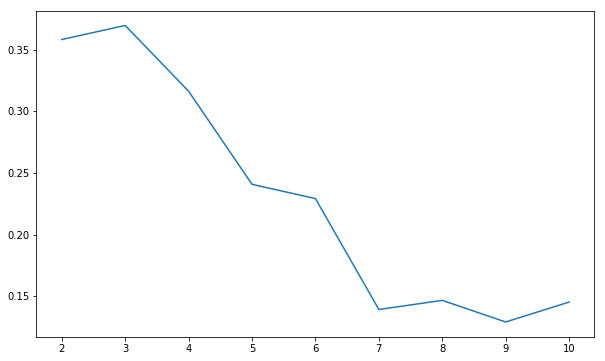

In [49]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
silhouettteScore = []
for i in range(2,11):
    kmeans = KMeans(n_clusters = i).fit(w_Scale)
    score = silhouette_score(w_Scale,kmeans.labels_)
    silhouettteScore.append(score)
plt.figure(figsize=(10,6))
plt.plot(range(2,11),silhouettteScore,linewidth=1.5,linestyle="-")
plt.show()

### （5）求取Calinski-Harabasz指数，确定最优聚类数目

In [27]:
from sklearn.metrics import calinski_harabaz_score
for i in range(2,11):
    kmeans = KMeans(n_clusters = i).fit(w_Scale)
    score = calinski_harabaz_score(w_Scale,kmeans.labels_)
    print(i,score)
    

2 111.35941852695352
3 126.96118428648934
4 98.78574928664392
5 79.84990567009848
6 68.35821624909767
7 61.16825936234546
8 55.724148264158494
9 51.522576372286586
10 48.053261735444345


## 3.构建基于wine数据集的SVM分类模型

### （1）读取wine数据集，区分标签和数据

In [39]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

w = pd.read_csv('wine.csv')

wt = w['Class']
wd = w.iloc[:,1:]

### （2）将wine数据集划分为训练集和测试集

In [40]:
from sklearn.model_selection import train_test_split

wt_train,wt_test,wd_train,wd_test = train_test_split(wt,wd,test_size = 0.25)

### （3）使用离差标准化方法标准化wine数据集

In [41]:
w_Scaler = MinMaxScaler().fit(wd_train)
w_trainMinMax = w_Scaler.transform(wd_train)
w_testMinMax = w_Scaler.transform(wd_test)

### （4）构建SVM模型，预测测试集结果

In [48]:
svm = SVC().fit(w_trainMinMax,wt_train)
prediction =svm.predict(w_testMinMax) 
print(prediction)
true = np.sum(prediction == wt_test)
print("true:",true)
print("wrong:",w_testMinMax.shape[0]-true)
print("true percentage:",true/w_testMinMax.shape[0])

[3 1 3 1 1 1 2 2 3 1 2 3 1 3 3 1 2 1 2 1 1 3 1 2 2 3 3 3 1 3 2 1 1 3 1 3 1
 2 3 3 1 2 1 2 1]


### （5）打印分类报告，评价分类模型性能

In [72]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,cohen_kappa_score
from sklearn.metrics import classification_report


print("Accuracy:",accuracy_score(wt_test,prediction))
print("Precision:",precision_score(wt_test,prediction,average=None))
print("Recall:",recall_score(wt_test,prediction,average=None))
print("F1:",f1_score(wt_test,prediction,average=None))
print("Cohen kappa:",cohen_kappa_score(wt_test,prediction))


print("Report:",classification_report(wt_test,prediction))


#ROC 曲线主要针对二分类模型，在此分三类能否套用？

Accuracy: 1.0
Precision: [1. 1. 1.]
Recall: [1. 1. 1.]
F1: [1. 1. 1.]
Cohen kappa: 1.0
Report:              precision    recall  f1-score   support

          1       1.00      1.00      1.00        19
          2       1.00      1.00      1.00        11
          3       1.00      1.00      1.00        15

avg / total       1.00      1.00      1.00        45



## 4.构建基于wine_quality数据集的回归模型

### （1）根据wine_quality数据集数据集处理结果，构建线性回归模型

### （2）根据wine_quality数据集数据集处理结果，构建梯度提升回归模型



### （3）结合真实评分和预测评分，计算均方误差，中值绝对误差，可解释方差值

### （4）根据得分，判定模型的性能优劣